Dans les cellules de code suivante, nous avons lancé plusieurs simulation de notre file pour observer l'évaluation du temps de réponse moyen pour chaque valeur de C {1; 2; 3; 6} en fonction de λ, puis pour évaluer le taux de rejet, toujours pour les mêmes valeurs de C, en fonction de λ.

In [55]:
import routeur

LAMBDA_REQUETE = 2.3

C = 1

T_MAX = 1000

routeur.simul_fifo(LAMBDA_REQUETE, C, T_MAX)

{'temp_moyen_attente_client': 24.520630833911778,
 'taux_rejet': 0.4477292202227935}

Code pour calculer l'intervalle de confiance suivant pour la moyenne tandis que nous ne connesions pas la variance selon le calcul de l'estimation de la variance sans biais puis de l'intervalle de confiance:

Estimation de la variance:

$$ V_n = \frac1{n-1} \sum_{i=1}^n (X_i - M_n)^2 $$

$n$ = nombre d'echantillon ici 10 échantillons seront utilisé \
$X$ = ensemble des moyennes simulé \
$Mn$ = moyenne de toutes les moyennes simulé : $ M_n = \sum_{i=1}^n \frac{X_i}{n} $

Intervalle de confiance :

$$\mathbb{P}\left[ \mu \in \left[\frac{S_n}{n} - \delta,  \frac{S_n}{n} + \delta \right]  \right] \geq 0.95 $$

avec:   $ \delta = 1.96 \frac{\sqrt{V_n}}{\sqrt{n}}$

* l'intervalle $\left[\frac{S_n}{n} - \delta,  \frac{S_n}{n} + \delta \right]$ est **l'intervalle de confiance** pour la moyenne $\mu$ avec une confiance $95\%$

In [2]:
def interval_conf_attente_client(lambda_requete, c, t_max):
    moy = 0
    taux_rejet_moy = 0
    elem = []
    for _ in range(ECHANTILLON):
        elem.append(routeur.simul_fifo(lambda_requete, c, t_max))
        taux_rejet_moy += (elem[-1]["taux_rejet"]) / ECHANTILLON
        moy += (elem[-1]["temp_moyen_attente_client"]) / ECHANTILLON
    
    # Estimation de la variance
    var = 0

    for i in range(ECHANTILLON):
        var += ((elem[i]["temp_moyen_attente_client"] - moy)**2) * (1 / (ECHANTILLON-1))
    
    d = 1.96*(((var/(ECHANTILLON))**0.5))

    return [moy, d, taux_rejet_moy]
    


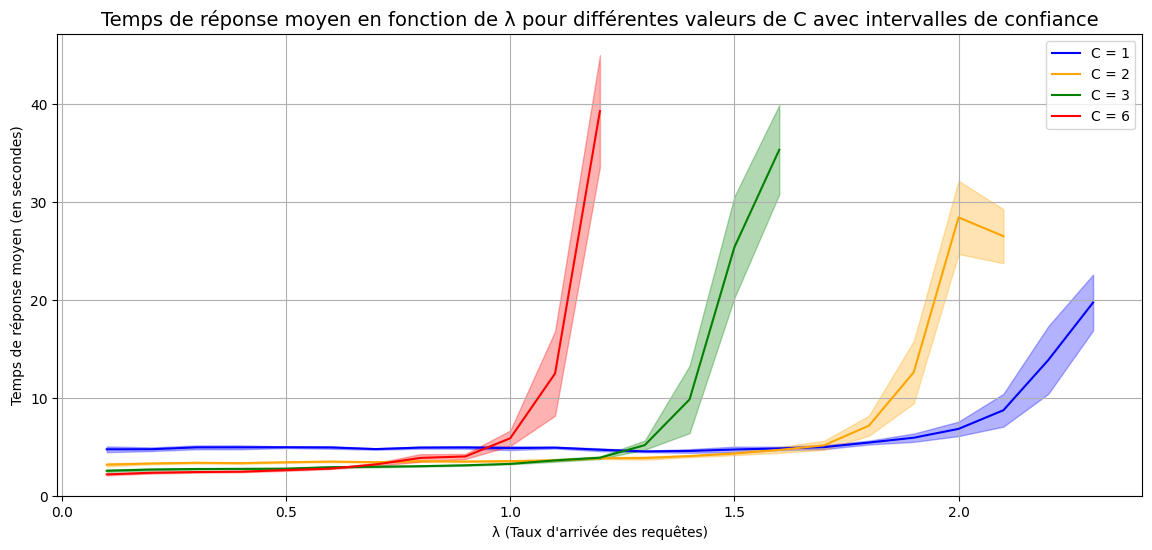

In [ ]:
import routeur
import matplotlib.pyplot as plt

# Paramètres de la simulation
T_MAX = 1000
STEP = 0.1
ECHANTILLON = 10
lambda_requete = 0.05

# Valeurs possibles pour C et leurs couleurs associées
C_values = [1, 2, 3, 6]
colors = {1: "blue", 2: "orange", 3: "green", 6: "red"}

# Liste pour stocker les résultats
data = []

# Simulation
for C in C_values:
    data.append({"temp_reponse_moyen": [], "borne_inf": [], "borne_sup": [], "C": C, "lambdas": []})
    lambda_requete = 0.1

    while True:
        # calcul intervalle de confiance et simulation
        m_d_r = interval_conf_attente_client(lambda_requete, C, T_MAX)

        # stockage
        data[-1]["lambdas"].append(lambda_requete)
        data[-1]["temp_reponse_moyen"].append(m_d_r[0])
        data[-1]["borne_inf"].append(m_d_r[0] - m_d_r[1])
        data[-1]["borne_sup"].append(m_d_r[0] + m_d_r[1])
        
        lambda_requete += STEP

        if m_d_r[2] > 0.05:
            break

# Tracer les courbes avec couleurs spécifiques
plt.figure(figsize=(14, 6))
for entry in data:
    C = entry["C"]
    color = colors[C]
    plt.plot(entry["lambdas"], entry["temp_reponse_moyen"], linestyle='-', color=color, label=f"C = {C}")
    plt.fill_between(entry["lambdas"], entry["borne_inf"], entry["borne_sup"], alpha=0.3, color=color)

# Mise en forme du graphique
plt.title("Temps de réponse moyen en fonction de λ pour différentes valeurs de C avec intervalles de confiance", size=14)
plt.xlabel("λ (Taux d'arrivée des requêtes)")
plt.ylabel("Temps de réponse moyen (en secondes)")
plt.grid(True)
plt.legend()
plt.show()


Nous pouvons observer que pour λ < 0.5, la solution C = 6 (6 groupes de 2 serveurs, en rouge) offre aux clients un temps d'attente marginalement meilleur par rapport aux solutions C = 3, C = 2 et C = 1. De λ =  0.8 à 1, la solution C = 3 est la meilleure. Pour λ compris entre 1.25 et 1.6, il faut choisir C = 2, puis C = 1 au-delà de λ = 1.65.

In [30]:
def interval_conf_taux_de_rejet(lambda_requete, c, t_max):
    moy = 0
    elem = []
    for _ in range(ECHANTILLON):
        elem.append(routeur.simul_fifo(lambda_requete, c, t_max))
        moy += (elem[-1]["taux_rejet"]) / ECHANTILLON
    
    # Estimation de la variance
    var = 0

    for i in range(ECHANTILLON):
        var += ((elem[i]["taux_rejet"] - moy)**2) * (1 / (ECHANTILLON-1))
    
    d = 1.96*(((var/(ECHANTILLON))**0.5))

    return [moy, d]
    

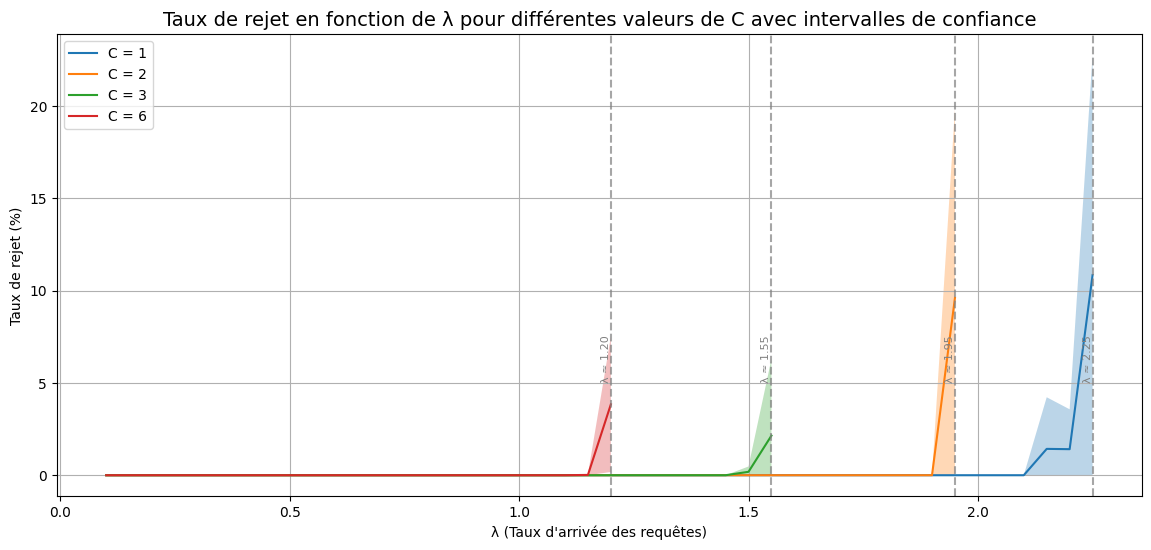

In [54]:
import routeur
import matplotlib.pyplot as plt
import numpy as np

# Paramètres de la simulation
T_MAX = 1000
STEP = 0.05
ECHANTILLON = 10
lambda_requete = 0.1

# Valeurs possibles pour C
C_values = [1, 2, 3, 6]

# Liste pour stocker les résultats
data = []

# Simulation
for C in C_values:
    courbe = {"taux_rejet": [], "borne_inf": [], "borne_sup": [], "C": C, "lambdas": [], "seuil_lambda": None}
    lambda_requete = 0.1

    while True:
        m_d_r = interval_conf_taux_de_rejet(lambda_requete, C, T_MAX)

        moyenne = m_d_r[0] * 100
        demi_ic = m_d_r[1] * 100

        borne_inf = max(0, moyenne - demi_ic)
        borne_sup = moyenne + demi_ic

        courbe["lambdas"].append(lambda_requete)
        courbe["taux_rejet"].append(moyenne)
        courbe["borne_inf"].append(borne_inf)
        courbe["borne_sup"].append(borne_sup)

        # Si l'intervalle dépasse 5 %, on enregistre la valeur seuil
        if borne_sup > 5 and courbe["seuil_lambda"] is None:
            courbe["seuil_lambda"] = lambda_requete
            break  # on peut sortir ici ou continuer selon ce que tu veux

        lambda_requete += STEP

    data.append(courbe)

# Tracer les courbes
plt.figure(figsize=(14, 6))
for courbe in data:
    C = courbe["C"]
    plt.plot(courbe["lambdas"], courbe["taux_rejet"], linestyle='-', label=f"C = {C}")
    plt.fill_between(courbe["lambdas"], courbe["borne_inf"], courbe["borne_sup"], alpha=0.3)

    # Ajouter le trait vertical en pointillé si seuil atteint
    if courbe["seuil_lambda"] is not None:
        plt.axvline(courbe["seuil_lambda"], linestyle='--', color='gray', alpha=0.7)
        plt.text(
            courbe["seuil_lambda"], 5, f"λ ≈ {courbe['seuil_lambda']:.2f}",
            rotation=90, va='bottom', ha='right', fontsize=8, color='gray'
        )

# Mise en forme
plt.title("Taux de rejet en fonction de λ pour différentes valeurs de C avec intervalles de confiance", size=14)
plt.xlabel("λ (Taux d'arrivée des requêtes)")
plt.ylabel("Taux de rejet (%)")
plt.grid(True)
plt.legend()
plt.show()


Sur ce deuxième graphe, nous voyons les taux d'arrivés pouvant être supportés par chacune des 4 solutions. On constate que les différentes solutions performent de manière très similaire à ce qu'on a vu sur le graphe précédent: Chaque courbe est "plate", jusqu'à ce que les performances s'écroulent très vite, et ce aux mêmes valeurs de λ. Cela s'explique par le fait qu'un taux de rejet plus important implique des problèmes pour servir chaque client, et donc des temps d'attentes plus longs, qui eux-mêmes renforcent l'effet de saturation subit par le système.